In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import LabelEncoder

## 1 Warmup

In [5]:
adult = fetch_openml(name='adult', version=1, parser='auto')
x_full = adult.data
y_full  = 1 * (adult.target == ">50K")
x_full = x_full.dropna()
y_full = y_full.loc[x_full.index]

In [6]:
features = adult.feature_names
features

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capitalgain',
 'capitalloss',
 'hoursperweek',
 'native-country']

In [7]:
le = LabelEncoder()
for feature in features:
    if x_full[feature].dtype == 'category':
        le.fit(x_full[feature])
        x_full.loc[:,feature] = le.transform(x_full[feature])

<ipython-input-7-864be50e7fbd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_full.loc[:,feature] = le.transform(x_full[feature])
<ipython-input-7-864be50e7fbd>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_full.loc[:,feature] = le.transform(x_full[feature])
<ipython-input-7-864be50e7fbd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_full.to_numpy(), y_full.to_numpy(), test_size=0.33, random_state=5)

In [9]:
clf = DecisionTreeClassifier(random_state=0, max_depth=2)

In [10]:
#Train the classifier below and report its accuaracy on the test set
clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
print(score*100)

82.45778611632271


## 2. Measuring Fairness

In [17]:
def demographic_disparity(predicted_labels, sensitive_attribute ):
  '''
  This function calculates the democraphic disparity between two groups.
  A value of 0 indicates parity between the groups, values larger then 0
  indicate Group A is privileged values smaller than 0 indicate Group B
  is privileged.
  Input:
  predicted_labels: nx1 array with the labels predicted by a binary classifier
  sensitive_attribute:  nx1 array where 1 indicates membership in Group A and
                        0 indicates a membership in Group B
  Output: Float between -1 and 1
  '''
  group_a = np.where(sensitive_attribute == 1)[0]
  group_b = np.where(sensitive_attribute == 0)[0]

  # f(x) = 1 | x in A or B
  count_a = len(np.where(predicted_labels[group_a] == 1)[0])
  count_b = len(np.where(predicted_labels[group_b] == 1)[0])

  prob_a = count_a / len(group_a)
  prob_b = count_b / len(group_b)

  return prob_a - prob_b

In [97]:
def equalized_odds(predicted_labels, true_labels, sensitive_attribute ):
  '''
  This function calculates how far a binary classifier is from achieving equalized odds.
  Input:
  predicted_labels: nx1 array with the labels predicted by a binary classifier
  true_labels: nx1 array with the actual labels of the data
  sensitive_attribute:  nx1 array where 1 indicates membership in Group A and
                        0 indicates a membership in Group B
  Output: Float between -1 and 1
  '''
  group_a = np.where(sensitive_attribute == 1)[0]
  group_b = np.where(sensitive_attribute == 0)[0]

  class_0 = np.where(true_labels == 0)[0]
  class_1 = np.where(true_labels == 1)[0]

  idx_a0 = np.intersect1d(group_a, class_0)
  idx_a1 = np.intersect1d(group_a, class_1)
  idx_b0 = np.intersect1d(group_b, class_0)
  idx_b1 = np.intersect1d(group_b, class_1)

  # f(x) = 1 | x = {A, B}, y = {0,1}
  count_a_class_0 = len(np.where(predicted_labels[idx_a0] == 1)[0])
  count_b_class_0 = len(np.where(predicted_labels[idx_b0] == 1)[0])
  count_a_class_1 = len(np.where(predicted_labels[idx_a1] == 1)[0])
  count_b_class_1 = len(np.where(predicted_labels[idx_b1] == 1)[0])

  prob_a0 = count_a_class_0 / len(idx_a0)
  prob_b0 = count_b_class_0 / len(idx_b0)
  prob_a1 = count_a_class_1 / len(idx_a1)
  prob_b1 = count_b_class_1 / len(idx_b1)

  return max(abs(prob_a0 - prob_b0), abs(prob_a1 - prob_b1))

In [99]:
def predictive_parity(predicted_labels, true_labels, sensitive_attribute):
  '''
  This function calculates how far a binary classifier is from achieving predictive_parity.
  Input:
  predicted_labels: nx1 array with the labels predicted by a binary classifier
  sensitive_attribute:  nx1 array where 1 indicates membership in Group A and
                        0 indicates a membership in Group B
  Output: Float The demographic disparity between Group A and B. Positive values
          indicate that Group A is privileged.
  '''
  group_a = np.where(sensitive_attribute == 1)[0]
  group_b = np.where(sensitive_attribute == 0)[0]

  class_0 = np.where(predicted_labels == 0)[0]
  class_1 = np.where(predicted_labels == 1)[0]

  idx_a0 = np.intersect1d(group_a, class_0)
  idx_a1 = np.intersect1d(group_a, class_1)
  idx_b0 = np.intersect1d(group_b, class_0)
  idx_b1 = np.intersect1d(group_b, class_1)

  # y = 1 | x = {A, B}, f(x) = {0,1}
  count_a_class_0 = len(np.where(true_labels[idx_a0] == 1)[0])
  count_b_class_0 = len(np.where(true_labels[idx_b0] == 1)[0])
  count_a_class_1 = len(np.where(true_labels[idx_a1] == 1)[0])
  count_b_class_1 = len(np.where(true_labels[idx_b1] == 1)[0])

  prob_a0 = count_a_class_0 / len(idx_a0)
  prob_b0 = count_b_class_0 / len(idx_b0)
  prob_a1 = count_a_class_1 / len(idx_a1)
  prob_b1 = count_b_class_1 / len(idx_b1)

  return max(abs(prob_a0 - prob_b0), abs(prob_a1 - prob_b1))

In [100]:
# Implement the above functions and report the fairness metrics
predicted = clf.predict(x_test)
sensitive_attribute = x_test[:, 9]

print("Demographic parity: ", demographic_disparity(predicted, sensitive_attribute))
print("Equalized odds: ", equalized_odds(predicted, y_test, sensitive_attribute ))
print("Predictive parity: ", predictive_parity(predicted, y_test, sensitive_attribute ))

Demographic parity:  0.19130945179372463
Equalized odds:  0.32035962015090985
Predictive parity:  0.27183451842275375


## 3. Inherent Neutrality of Data

## 4.  Fairness through unawarness

In [101]:
unaware_clf = DecisionTreeClassifier(random_state=0, max_depth=2)
# Create a new training set and train the unaware classifier
unaware_x_train = np.delete(x_train, 9, axis=1)
unaware_x_test = np.delete(x_test, 9, axis=1)

unaware_clf.fit(unaware_x_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [104]:
#Report the fairness metrics and accuracy
score = unaware_clf.score(unaware_x_test, y_test)
print("Test Acc: ", score)

predicted = unaware_clf.predict(unaware_x_test)
sensitive_attribute = x_test[:, 9]

print("Demographic parity: ", demographic_disparity(predicted, sensitive_attribute))
print("Equalized odds: ", equalized_odds(predicted, y_test, sensitive_attribute ))
print("Predictive parity: ", predictive_parity(predicted, y_test, sensitive_attribute ))

Test Acc:  0.8245778611632271
Demographic parity:  0.19130945179372463
Equalized odds:  0.32035962015090985
Predictive parity:  0.27183451842275375


##  5.  Removing an additional  attribute

<Axes: >

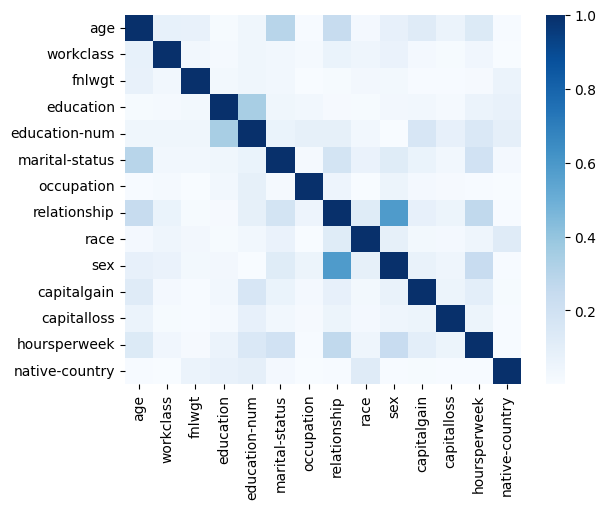

In [109]:
corr = x_full.corr().abs()
import seaborn as sns

sns.heatmap(corr, cmap='Blues')

In [115]:
more_unaware_clf = DecisionTreeClassifier(random_state=0, max_depth=2)

# Create a new training set and train the more_unaware classifier
more_unaware_x_train = np.delete(x_train, [7, 9], axis=1)
more_unaware_x_test = np.delete(x_test, [7, 9], axis=1)

more_unaware_clf.fit(more_unaware_x_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [116]:
#Report the fairness metrics and accuracy
score = more_unaware_clf.score(more_unaware_x_test, y_test)
print("Test Acc: ", score)

predicted = more_unaware_clf.predict(more_unaware_x_test)
sensitive_attribute = x_test[:, 9]

print("Demographic parity: ", demographic_disparity(predicted, sensitive_attribute))
print("Equalized odds: ", equalized_odds(predicted, y_test, sensitive_attribute ))
print("Predictive parity: ", predictive_parity(predicted, y_test, sensitive_attribute ))

Test Acc:  0.8133208255159474
Demographic parity:  0.11026284937586332
Equalized odds:  0.04500082860376903
Predictive parity:  0.2227864655796093
